![Fraud](./img/Fraud.png)
# Employment Scam Aegean Dataset
## 0. Imports and global settings

In [1]:
import scripts.plots as plots
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import FreqDist, RegexpTokenizer, word_tokenize
import pandas as pd
import re
import seaborn as sns
import string
import warnings
from wordcloud import WordCloud

sns.set(palette='RdYlGn', context='talk', rc={'figure.figsize':(15,15)})
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2

## 0.1 Creating dataframes

In [2]:
df = pd.read_csv("./data/fake_job_postings.csv", index_col='job_id')
df.columns = df.columns.str.title()

In [3]:
dflegit = df[df['Fraudulent']==0]
dffraud = df[df['Fraudulent']==1]

In [4]:
df.sample(n=50)

Title  \
job_id                                                      
9446                  Care Assistant (Personal Assistant)   
12303                               Marketing Coordinator   
4066                            Business and Data Analyst   
5603                          People and Culture Manager    
13340                                      Cloud engineer   
2209                       Associate Business Development   
11497                                   Director of Sales   
14495                                 Network Engineer II   
9755                                    Automotive Writer   
7098                                             Attorney   
8932                                        Product Owner   
4763                  Community Management / User Support   
187                                         Receptionist    
8170                                       .Net Developer   
2795                       Web & User Experience Designer   
434                       Scrum Master/Project Management   
5643                                 Sales Representative   
15006                     Enterprise Sales Representative   
4011                                  Front-End Developer   
4898              Customer Service Associate - Part Time    
5939                                BizTalk Administrator   
14284                             English Teacher Abroad    
757                                Player Insight Analyst   
2857             Analista Comercial (Servicio a clientes)   
11980   Stock Administrator Job opportunity at Califor...   
9018                          Customer Service Associate    
7938                                   CDL Driver-Addison   
2898                                  Support Team Member   
8220                                    Software Engineer   
6965              English Teacher Abroad (Conversational)   
12509                     Digital Marketing Manager - B2B   
15317                             English Teacher Abroad    
14697   Sr. Android Software Engineer - Agile SCRUM AR...   
9700              Driver - Medium Duty (Santa Fe Springs)   
17209   Birmingham Business Admin Apprenticeship Under...   
4648                         Program Host, Hausa Language   
9356    BB11 5TD Business Admin Apprenticeship Under N...   
10778                              Senior Database Expert   
1458                                INVESTMENT SPECIALIST   
16637                                Sales Representative   
8339    Awesome Roommate Wanted -$1650 Utilities Included   
5925                                 Developer Evangelist   
6338                       Trainee Recruitment Consultant   
4837                                          Intern: Dev   
2056                                Design & Home Editor    
8710            In-House Graphic Designer at MacTay Group   
6874                              Care Assistant - Meigle   
10409                             English Teacher Abroad    
9080    Graduates: English Teacher Abroad (Conversatio...   
9481       Campaign Assistance (part-time incl. weekends)   

                                       Location                 Department  \
job_id                                                                       
9446    GB, EDH, Edinburgh South and South East                        NaN   
12303                           GB, LND, London                  Marketing   
4066                           CA, ON, Waterloo                        NaN   
5603                            GB, LND, London                        NaN   
13340                         IN, KA, bangalore                        NaN   
2209                       FR, , Work from home                        NaN   
11497                           US, CA, Burbank                      Sales   
14495                           US, AZ, Phoenix                        NaN   
9755                            GB, LND, London                    Content   
7098                 

## 1. Missing values
Let's have a look at the data and see if there are any missing values.

In [5]:
_nalegit = pd.DataFrame(index=['Legit_HasValue','Legit_IsNA'])
_nafraud = pd.DataFrame(index=['Fraud_HasValue', 'Fraud_IsNA'])
for header in dflegit.columns:
    _nalegit[header] = dflegit[header].isna().value_counts()[0]
_nalegit.loc['Legit_IsNA'] = 17014 - _nalegit.loc['Legit_HasValue']
for header in dffraud.columns:
    _nafraud[header] = dffraud[header].isna().value_counts()[0]
_nafraud.loc['Fraud_IsNA'] = 866 - _nafraud.loc['Fraud_HasValue']
_nalegit = (round(_nalegit/17014*100, 1)).T
_nafraud = (round(_nafraud/866*100,1)).T
_na = _nalegit.merge(_nafraud,how='inner',left_on=_nalegit.index, right_on=_nafraud.index)
_na = _na.set_index(_na['key_0']).drop(columns='key_0')
_na.index.names = ['Columns']
_na

Legit_HasValue  Legit_IsNA  Fraud_HasValue  Fraud_IsNA
Columns                                                                    
Title                         100.0         0.0           100.0         0.0
Location                       98.1         1.9            97.8         2.2
Department                     35.3        64.7            38.7        61.3
Salary_Range                   15.5        84.5            25.8        74.2
Company_Profile                84.0        16.0            32.2        67.8
Description                   100.0         0.0            99.9         0.1
Requirements                   85.1        14.9            82.2        17.8
Benefits                       59.8        40.2            58.0        42.0
Telecommuting                 100.0         0.0           100.0         0.0
Has_Company_Logo              100.0         0.0           100.0         0.0
Has_Questions                 100.0         0.0           100.0         0.0
Employment_Type                81.0        19.0            72.2        27.8
Required_Experience            61.1        38.9            49.8        50.2
Required_Education             55.0        45.0            47.9        52.1
Industry                       72.8        27.2            68.2        31.8
Function                       64.0        36.0            61.1        38.9
Fraudulent                    100.0         0.0           100.0         0.0

17014


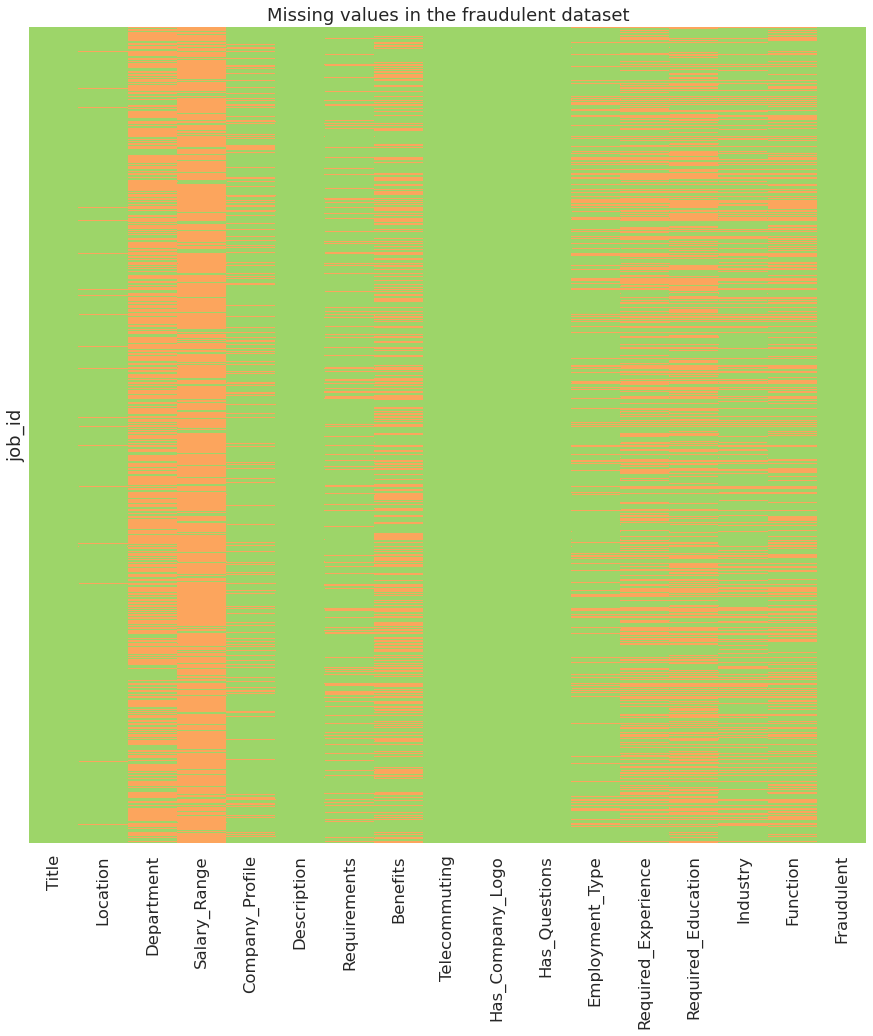

In [6]:
print(len(dflegit))
sns.heatmap(dflegit.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[4],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

866


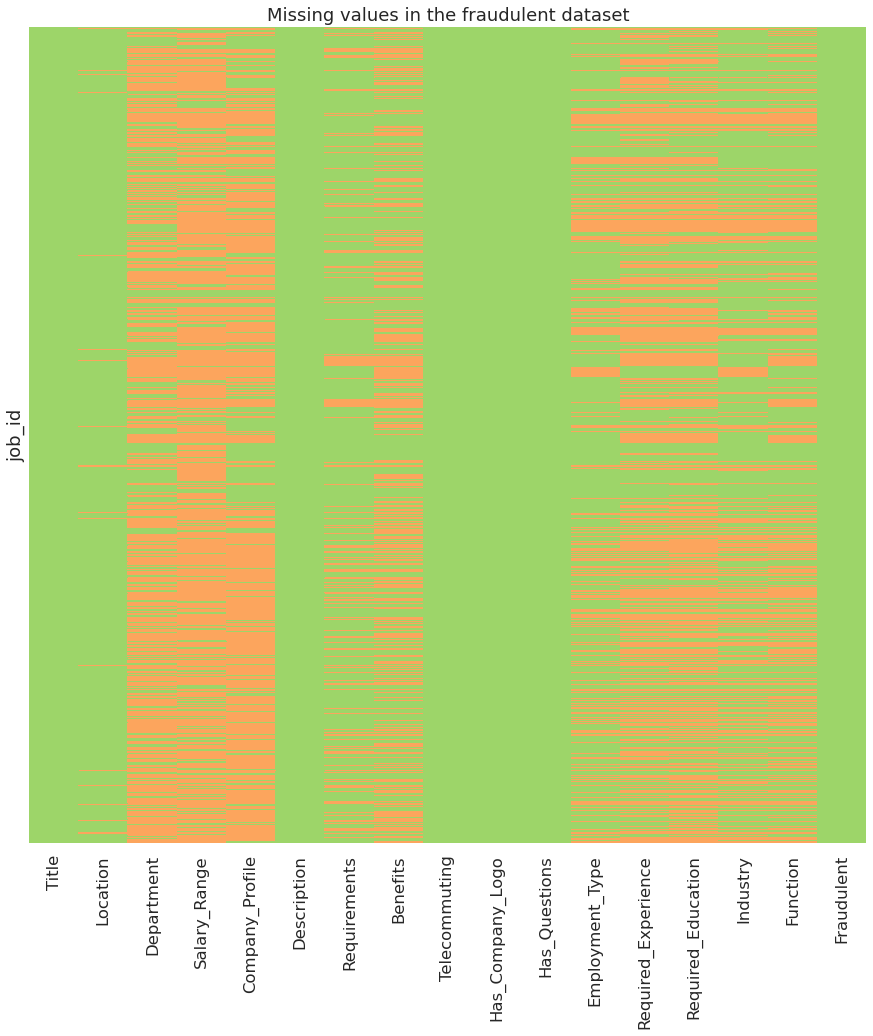

In [7]:
print(len(dffraud))
sns.heatmap(dffraud.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[4],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

## 1.1 Insight
This dataset contains 17880 jobs, with a maximum of 16 characteristics given to each job. On top of this information, all jobs entry have been assigned manually a "fraudulent" value of 1 (the post is fraudulent) or 0 (the post is legitimate); this resulted in 17014 job offers flagged as genuine whilst 866 were identified as fraudulent.

_Note: This assignment was done manually. Errors might have occurred._

The informations given for each job is separated in the following variables:

| Number | Title | Data type |
|---:|:---:| ---|
| 01 | title | text |
| 02 | location | text |
| 03 | department | text |
| 04 | salary_range | text |
| 05 | company_profile | text |
| 06 | description | text |
| 07 | requirements | text |
| 08 | benefits | text |
| 09 | telecommuting | binary |
| 10 | has_company_logo | binary |
| 11 | has_questions | binary |
| 12 | employment_type | categorical |
| 13 | required_experience | categorical |
| 14 | required_education | categorical |
| 15 | industry | categorical |
| 16 | function | categorical |
| 17 | fraudulent | binary |

There tend to be some repetitions in some fields; `company_profile` is an obvious one but, `description` can be very similar in some cases. These repetitions might affect tf-idf scores and might require a more in-depth analysis.

As the missing table shows, fraudulent posts tend to have more missing values than legitimate job posts, especially when it comes down to company profile. However, they seem to be rather keen on giving information about the salary range. Only one job doesn't have a job description (`df[df['description'].isna()==True]`); it is a fraudulent post for a position as an Office Manager in Warsaw, PL.

## 2. Text fields
From the missing value visualisation, we can see the fraudsters are struggling with the company profiles, etc. Let's look at text fields, in general, to see how creative the fraudsters are.
### 2.1 Trimming the text
There is some textual artefact that ned to be removed in order to have a more efficient word analysis.

In the following code,
- The first line will put a space before every capital letter (to avoid a wo.Rd scenario).
- The second line will remove the anonymised contact information.
- The third line will remove non-word characters, including digits.
- The fourth line will remove words shorter than three characters.
- The fifth line will convert multiple spaces into one space only.

In [8]:
for column in df.columns[4:8]:
    df[column].replace('([A-Z][a-z]|[A-Z] )', r' \1', regex=True, inplace=True)
    df[column].replace('(#URL\w+|#PHONE\w+|#EMAIL\w+)', ' ', regex=True, inplace=True)
    df[column].replace('(\\W|\\d)', ' ', regex=True, inplace=True)
    df[column].replace(r'\b\w{1,3}\b', ' ', regex=True, inplace=True)
    df[column].replace('\ +', ' ', regex=True, inplace=True)

### 2.2 Word Count
Next step is to look at how long posts are and, more specifically, if any difference between fraudulent posts and genuine ones exists.

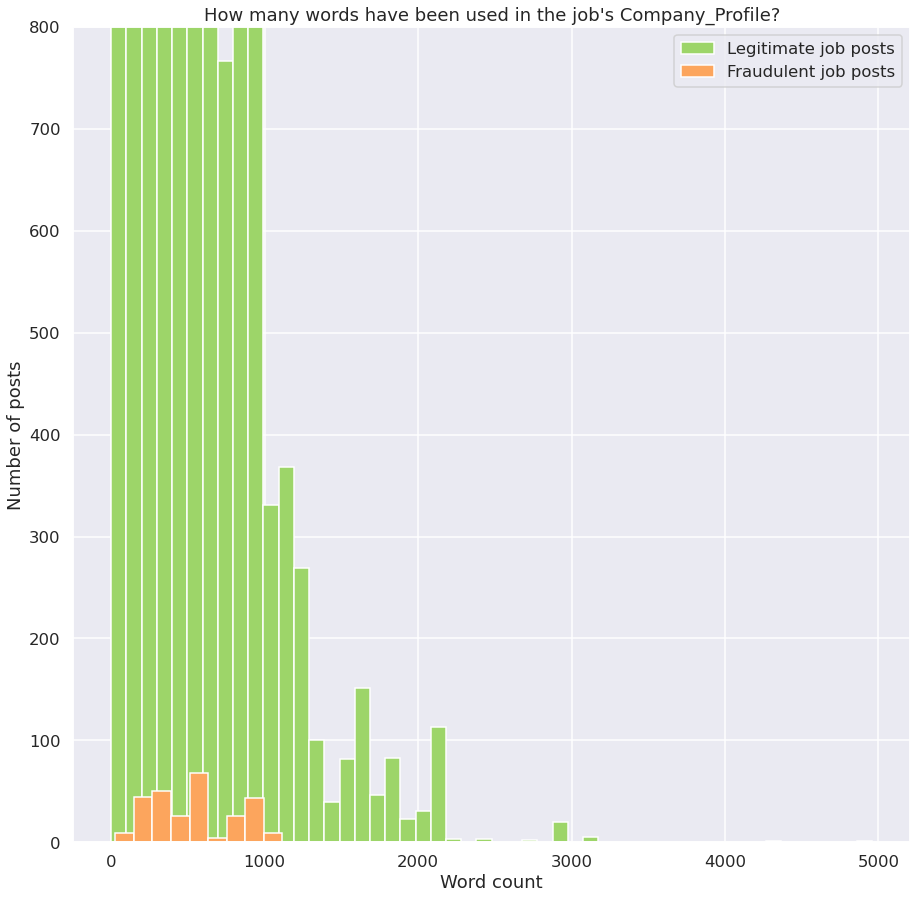

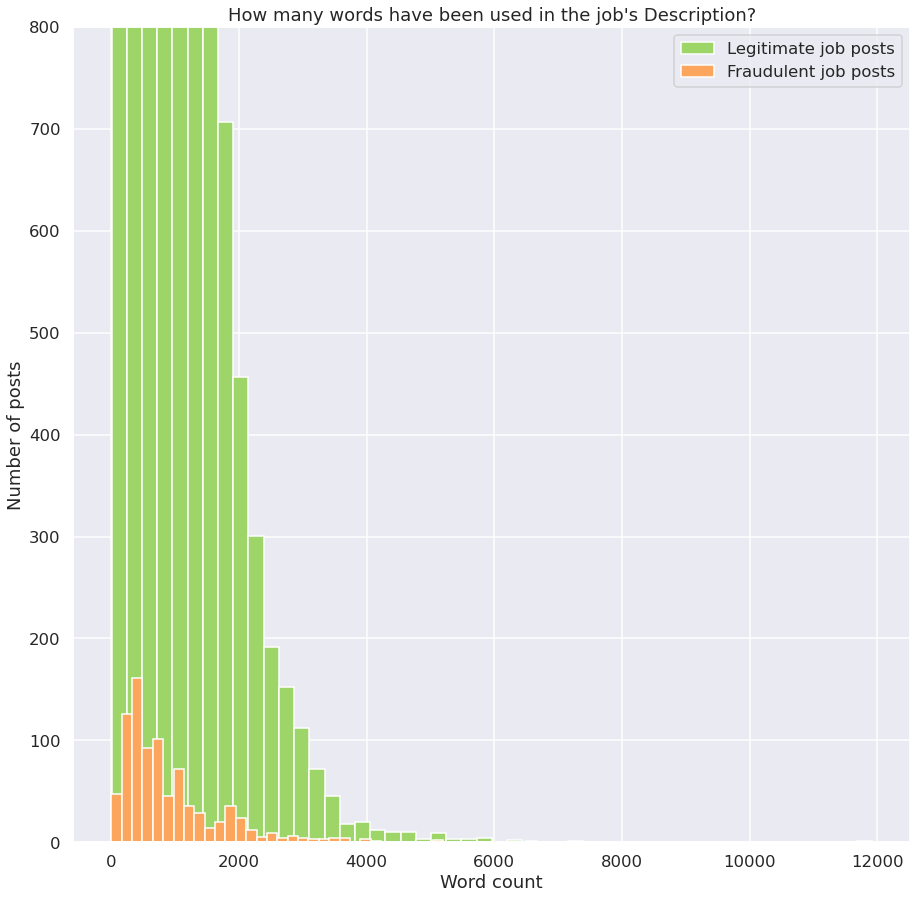

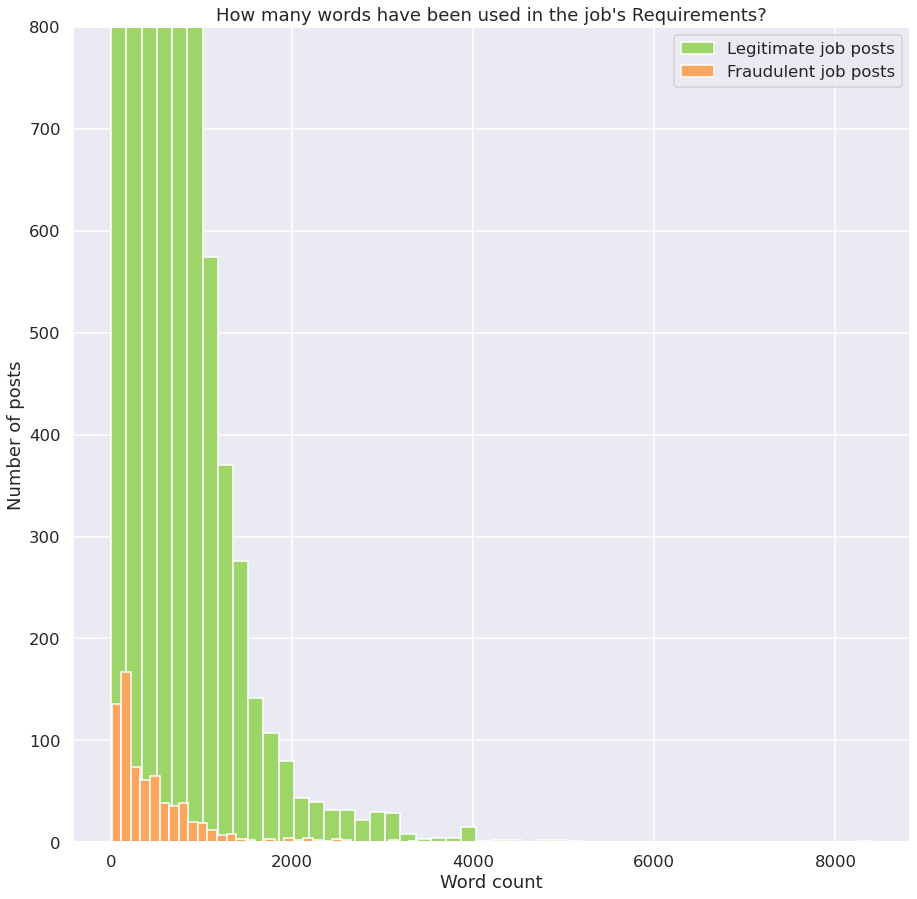

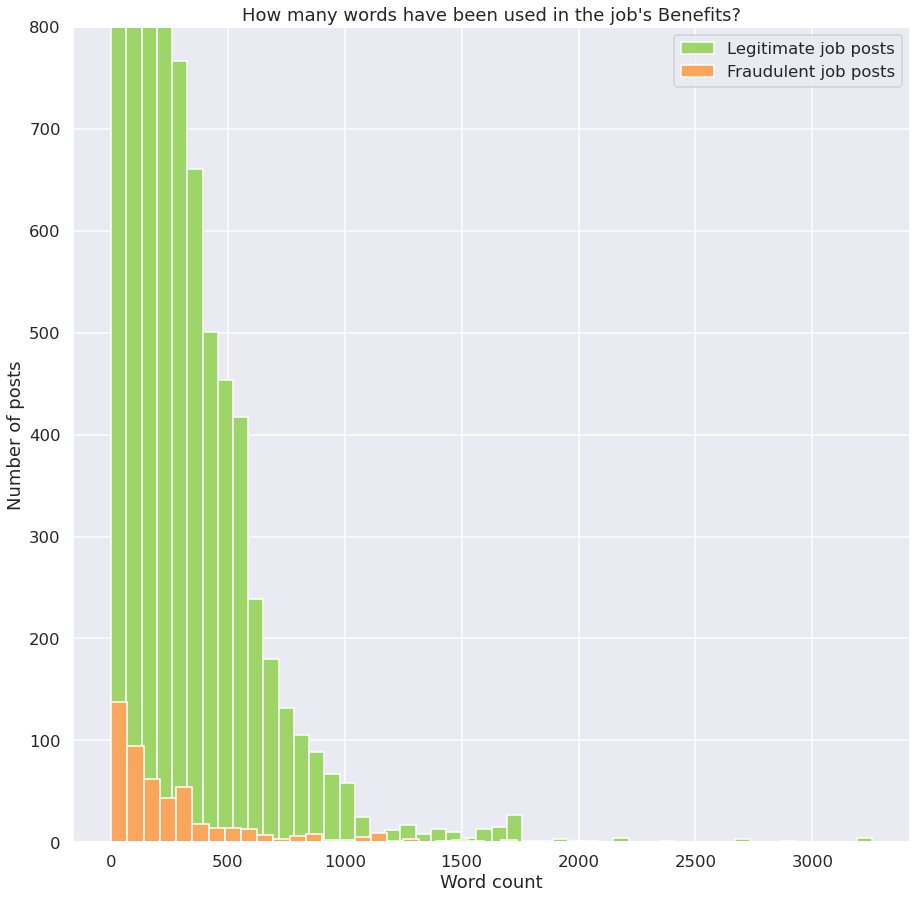

In [9]:
plots.Plots.word_dist_plot(df,4,8)

Not only are fraudulent job posts less complete than legitimate ones but, even when there is information, the fraudulent job posts are less loquacious than genuine job posts. This is especially true for job requirements and company_profile.

Let's have a more detailed look at the content itself.
### 2.3 Vocabulary Analysis
#### 2.3.1 Company Profile

In [10]:
# Removing stopwords
stop_words = list(string.punctuation)
stop_words += stopwords.words('english')
stop_words += [i for i in 'qwertyuioplkjhgfdsazxcvbnm0']

In [11]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in df['Company_Profile']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [12]:
len(tokens_cp)

945056

In [13]:
vocab = {}
for i in tokens_cp:
    vocab[i] = vocab.get(i, 0) + 1

orderedvocab = sorted(vocab.items(), key=lambda x:x[1], reverse=True)

In [14]:
total = 0
wcount = 0
breakvalue = .9 * len(tokens_cp)
for k, v in orderedvocab:
    if total < breakvalue:
        total += v
        wcount += 1
    else:
        print(f"length of vocab: {wcount}\ncount of words: {v}")
        break

length of vocab: 2877
count of words: 44


#### 2.3.1.1 Company Profiles of Fraudulent Posts

In [15]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dffraud['Company_Profile']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [16]:
len(tokens_cp)

18184

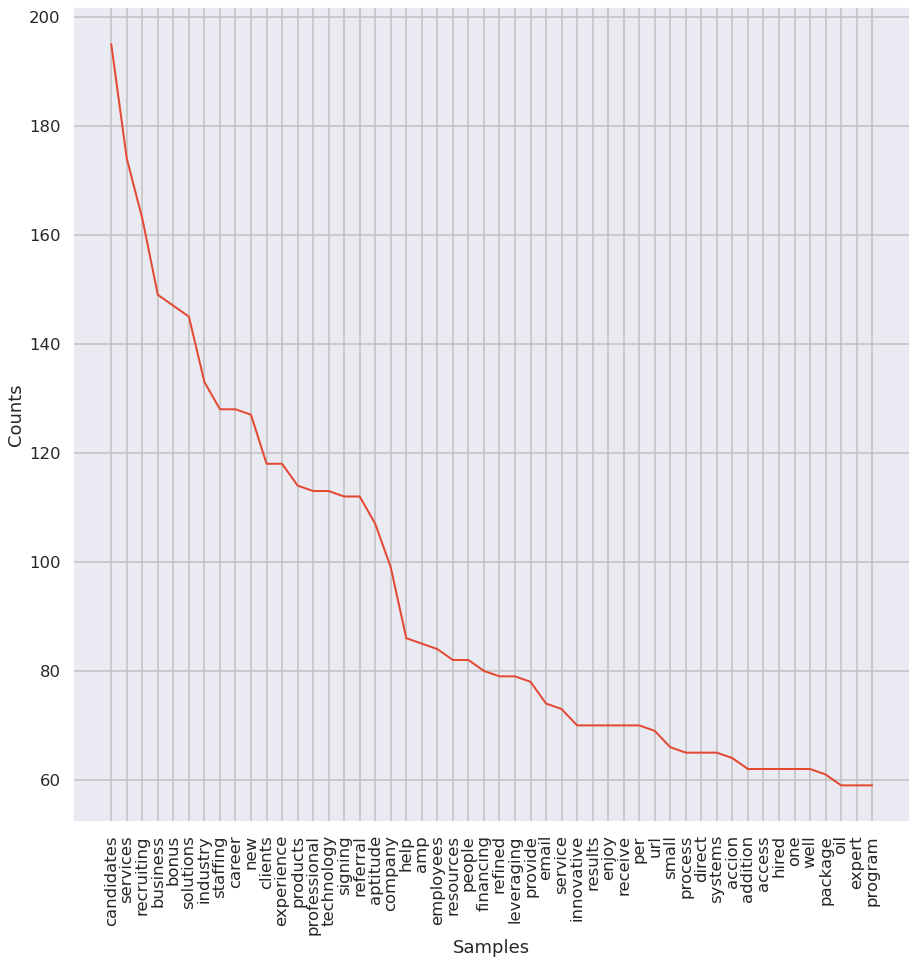

In [17]:
FreqDist(tokens_cp).plot(50)
plt.show()

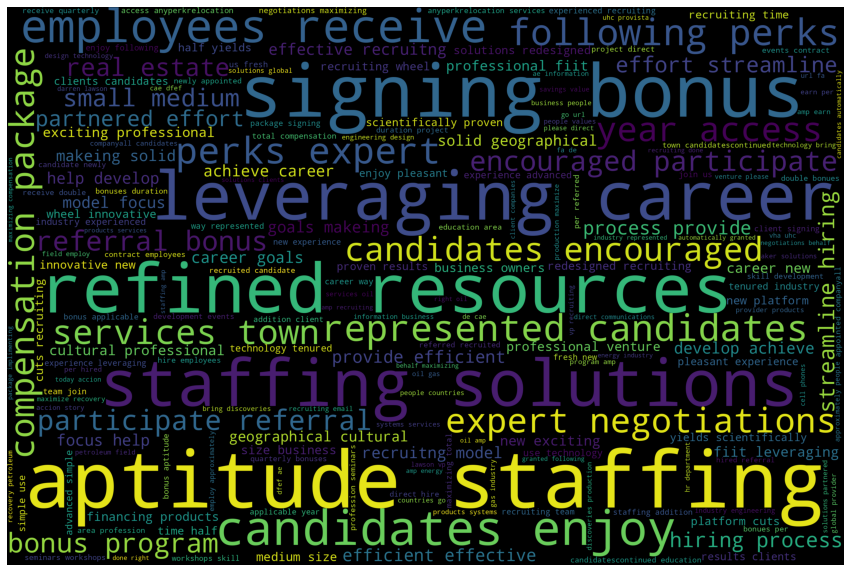

In [18]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 2.3.1.2 Company Profile of Legitimate Posts

In [19]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dflegit['Company_Profile']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [20]:
len(tokens_cp)

1016833

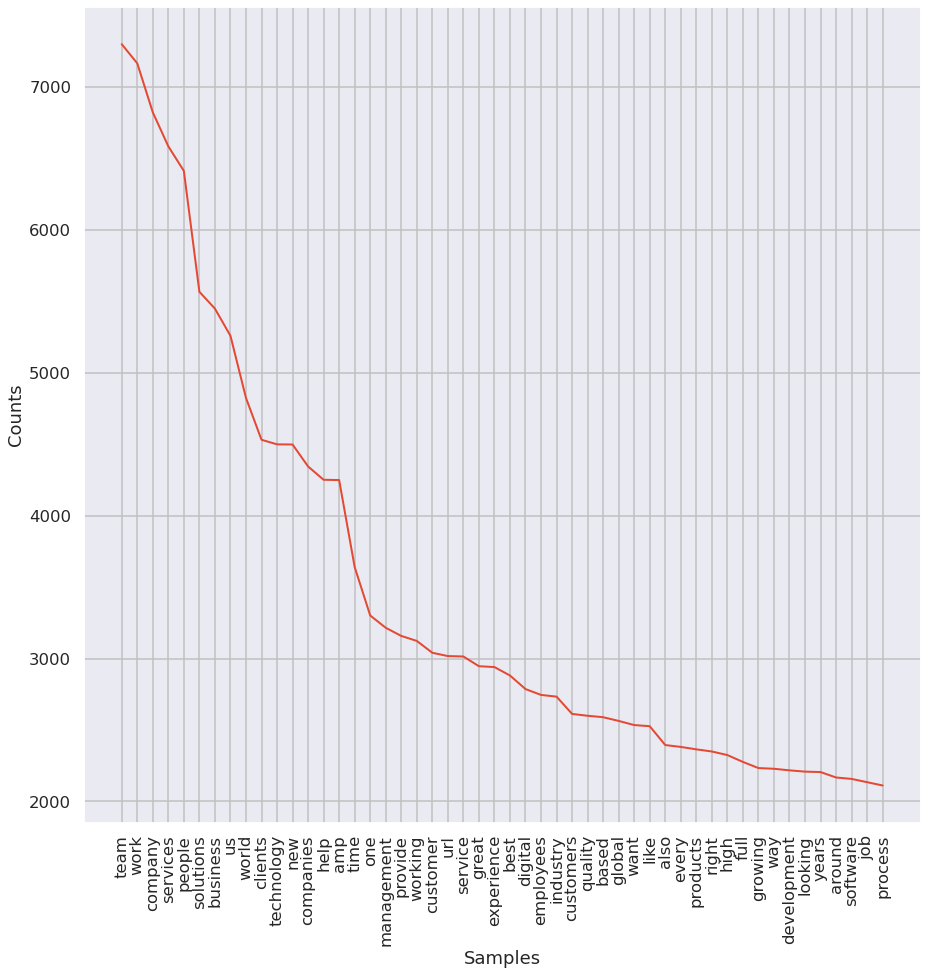

In [21]:
FreqDist(tokens_cp).plot(50)
plt.show()

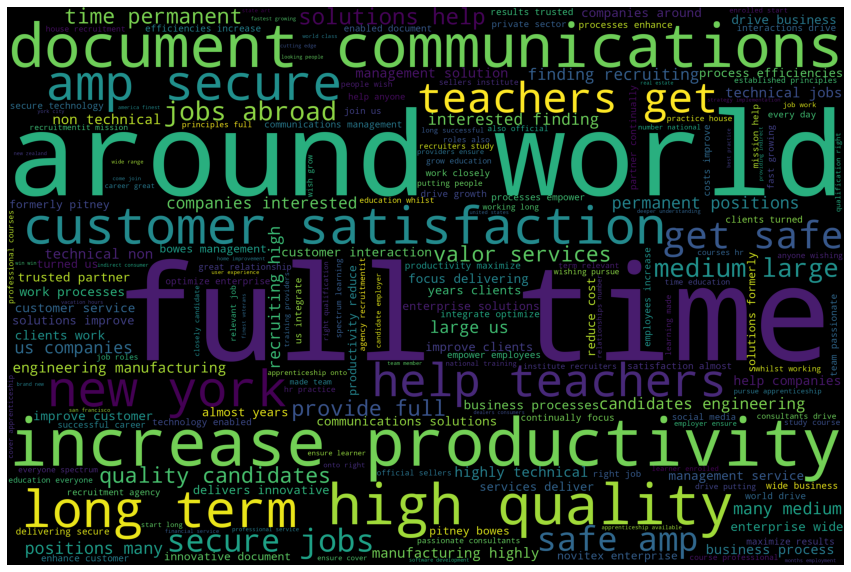

In [22]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Looking at the content of fraudulent ads, it appears, the company profile would be more individual focussed, with terms like candidates, recruiting, bonus, staffing, career, signing, referral, etc.

A legitimate company seem to be more mission focussed with terms like team, people, solutions, help, business, etc.

### 2.3.2 Description

In [23]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in df['Description']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [24]:
len(tokens_cp)

1880099

In [25]:
vocab = {}
for i in tokens_cp:
    vocab[i] = vocab.get(i, 0) + 1

orderedvocab = sorted(vocab.items(), key=lambda x:x[1], reverse=True)

In [26]:
total = 0
wcount = 0
breakvalue = .9 * len(tokens_cp)
for k, v in orderedvocab:
    if total < breakvalue:
        total += v
        wcount += 1
    else:
        print(f"length of vocab: {wcount}\ncount of words: {v}")
        break

length of vocab: 3391
count of words: 64


#### 2.3.2.1 Description of Fraudulent Posts

In [27]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dffraud['Description']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [28]:
len(tokens_cp)

94401

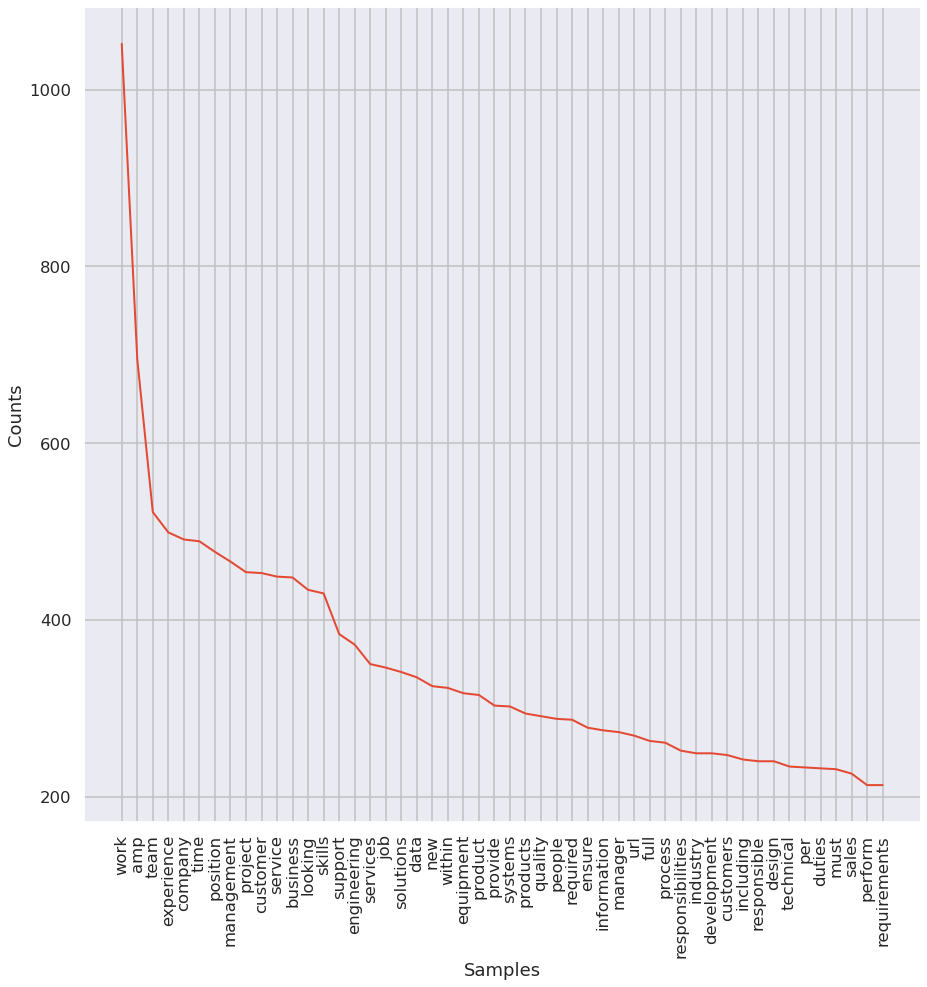

In [29]:
FreqDist(tokens_cp).plot(50)
plt.show()

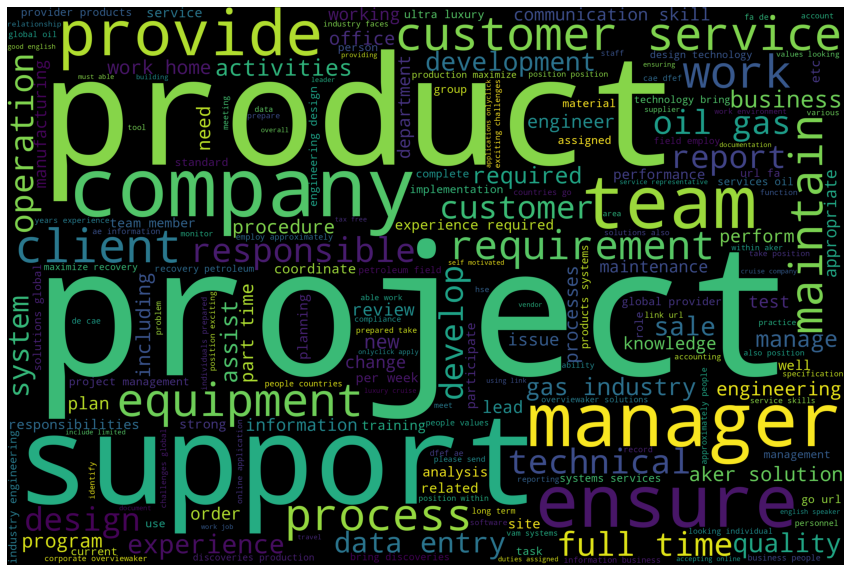

In [30]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 2.3.2.2 Description of Legitimate Posts

In [31]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dflegit['Description']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [32]:
len(tokens_cp)

1911962

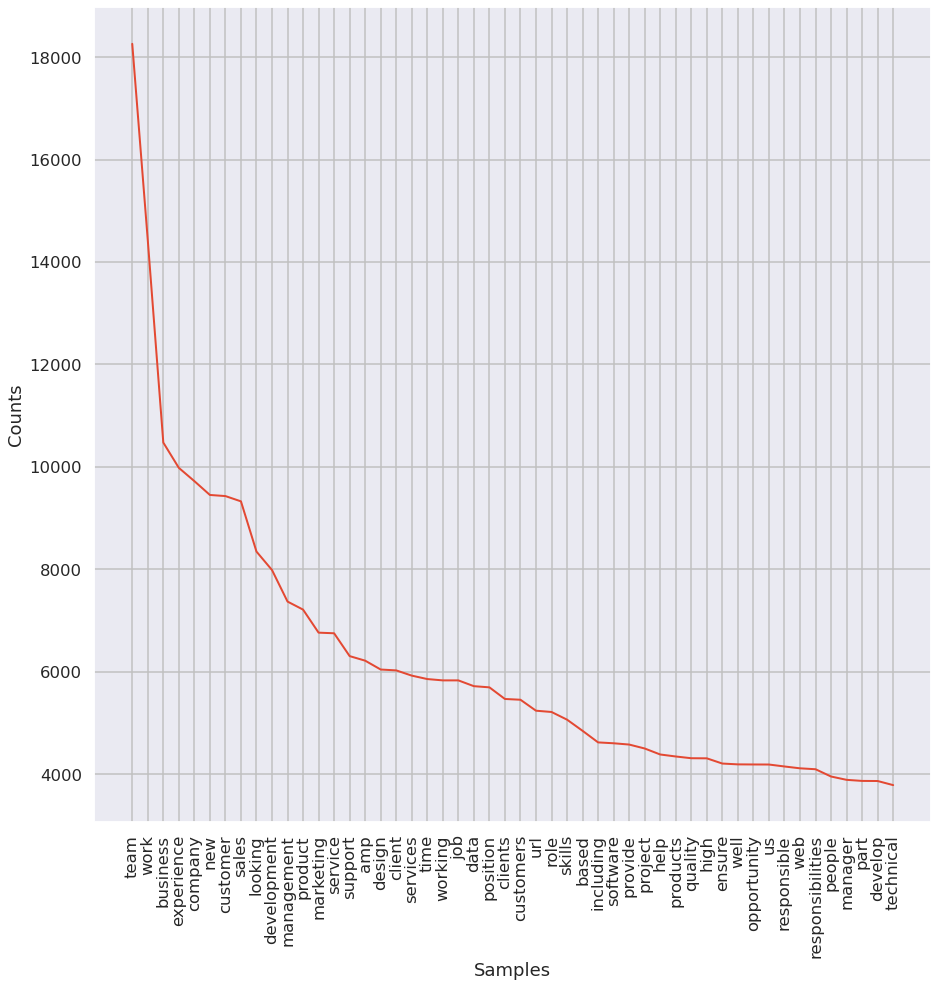

In [33]:
FreqDist(tokens_cp).plot(50)
plt.show()

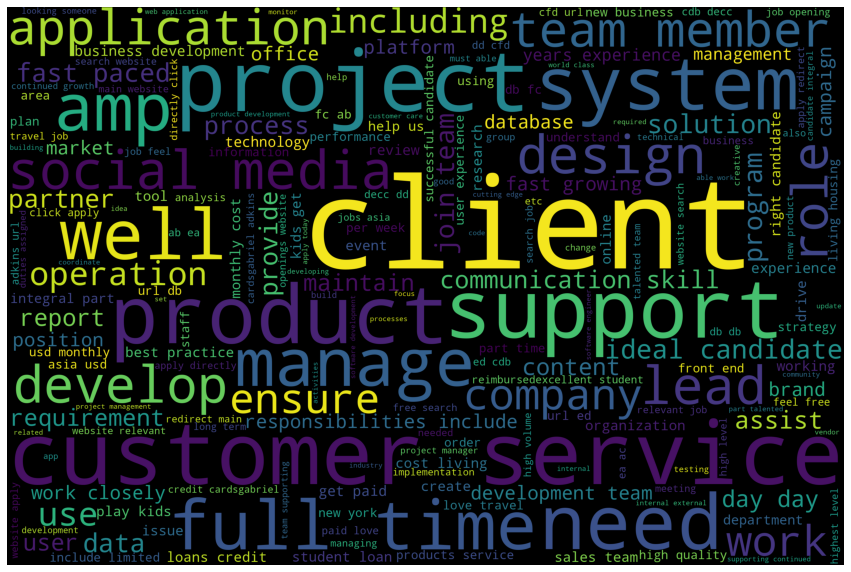

In [34]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### 2.3.3 Requirements

In [35]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in df['Requirements']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [36]:
len(tokens_cp)

955963

In [37]:
vocab = {}
for i in tokens_cp:
    vocab[i] = vocab.get(i, 0) + 1

orderedvocab = sorted(vocab.items(), key=lambda x:x[1], reverse=True)

In [38]:
total = 0
wcount = 0
breakvalue = .9 * len(tokens_cp)
for k, v in orderedvocab:
    if total < breakvalue:
        total += v
        wcount += 1
    else:
        print(f"length of vocab: {wcount}\ncount of words: {v}")
        break

length of vocab: 2406
count of words: 43


#### 2.3.3.1 Requirements of Fraudulent Posts

In [39]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dffraud['Requirements']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [40]:
len(tokens_cp)

36706

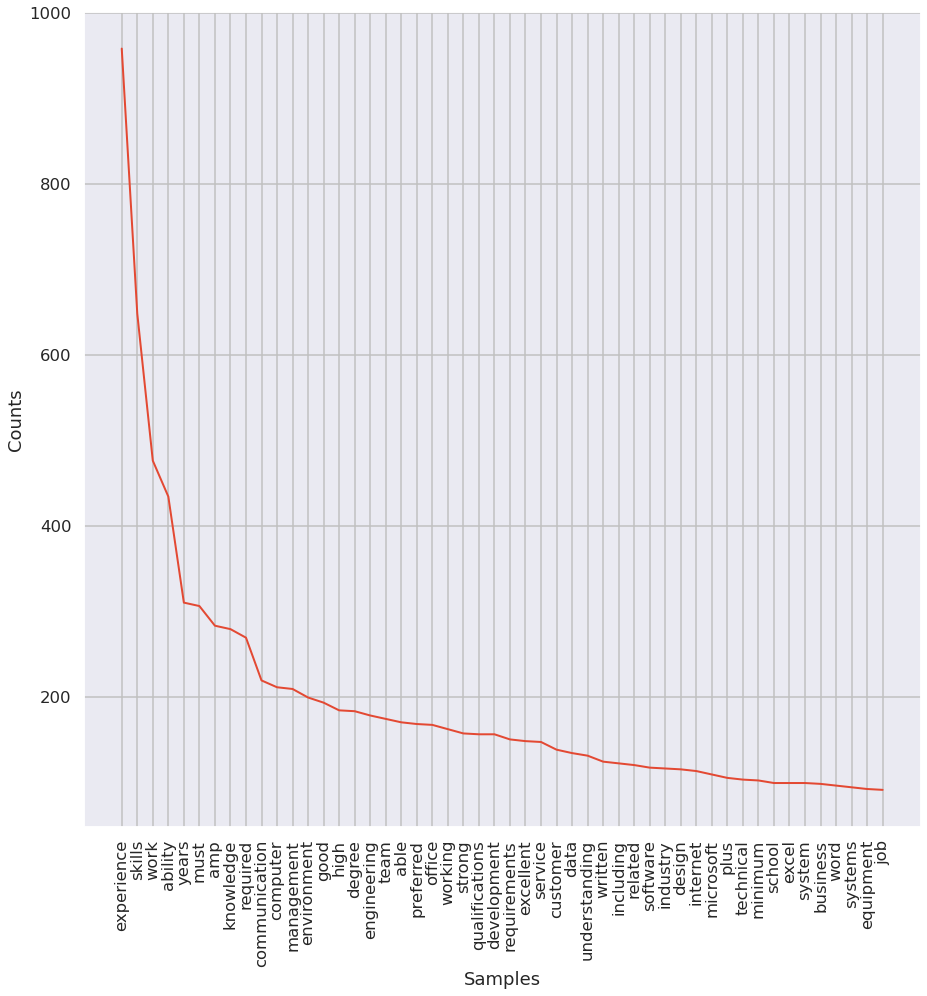

In [41]:
FreqDist(tokens_cp).plot(50)
plt.show()

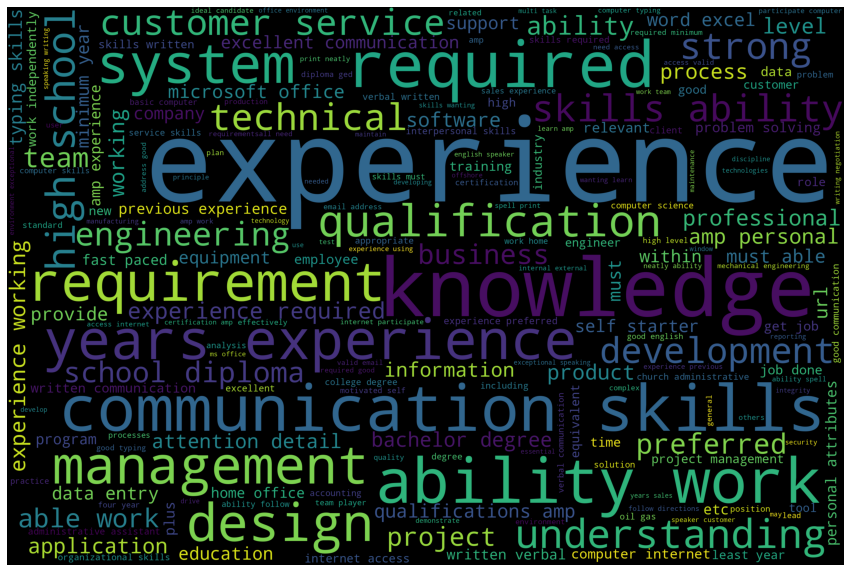

In [42]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 2.3.3.2 Description of Requirements Posts

In [43]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dflegit['Requirements']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [44]:
len(tokens_cp)

946331

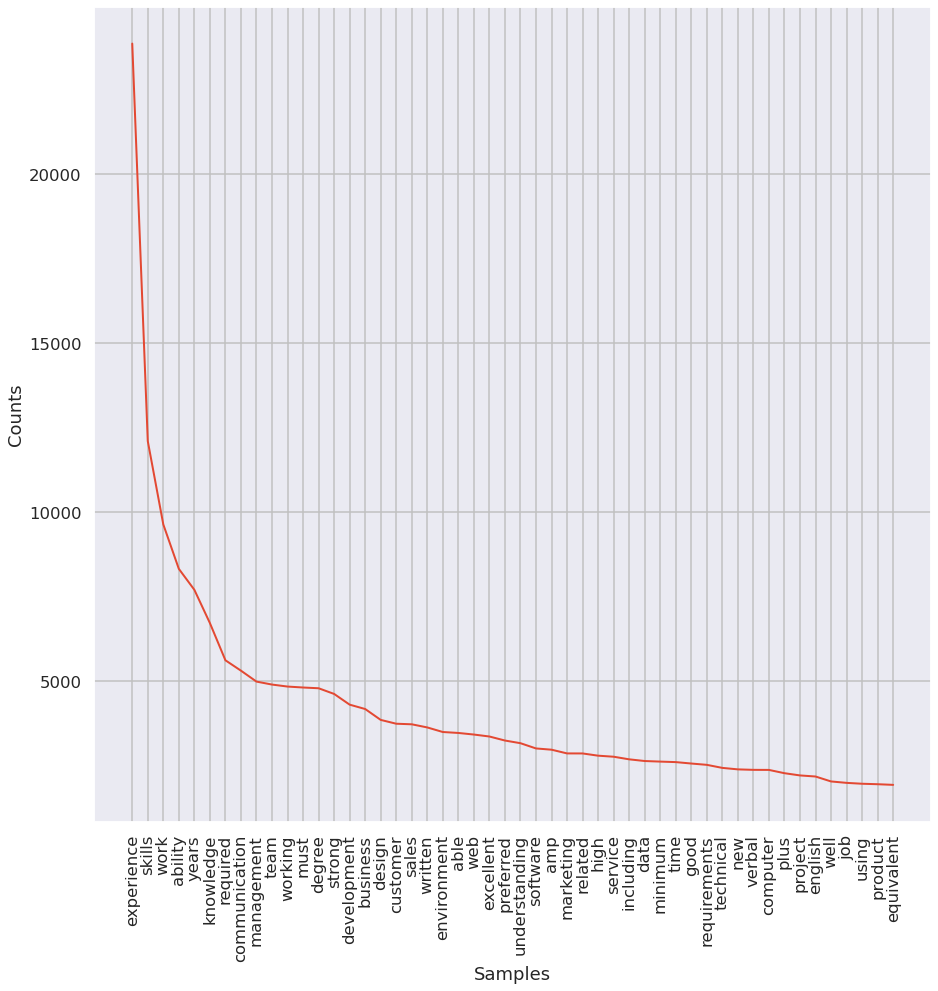

In [45]:
FreqDist(tokens_cp).plot(50)
plt.show()

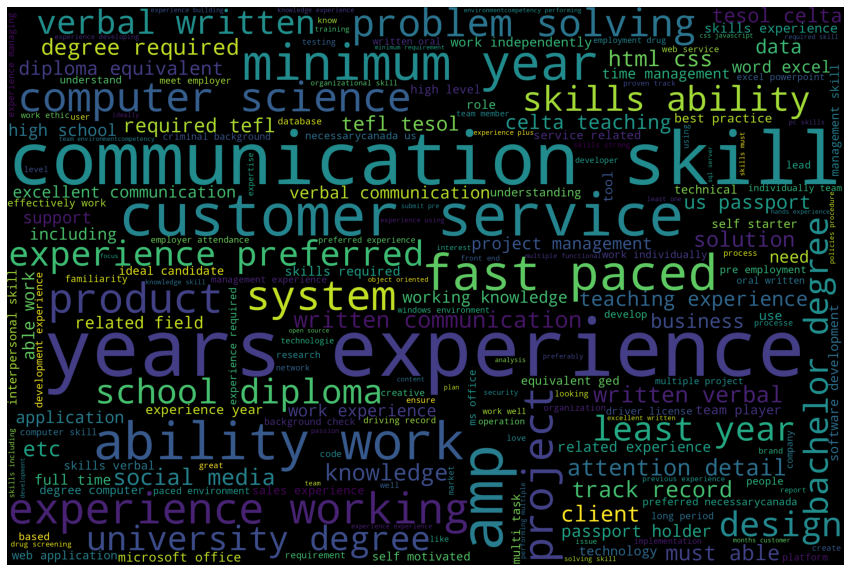

In [46]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### 2.3.4 Benefits

In [47]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in df['Benefits']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [48]:
len(tokens_cp)

330800

In [49]:
vocab = {}
for i in tokens_cp:
    vocab[i] = vocab.get(i, 0) + 1

orderedvocab = sorted(vocab.items(), key=lambda x:x[1], reverse=True)

In [50]:
total = 0
wcount = 0
breakvalue = .9 * len(tokens_cp)
for k, v in orderedvocab:
    if total < breakvalue:
        total += v
        wcount += 1
    else:
        print(f"length of vocab: {wcount}\ncount of words: {v}")
        break

length of vocab: 1988
count of words: 20


#### 2.3.4.1 Requirements of Fraudulent Posts

In [51]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dffraud['Benefits']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [52]:
len(tokens_cp)

17033

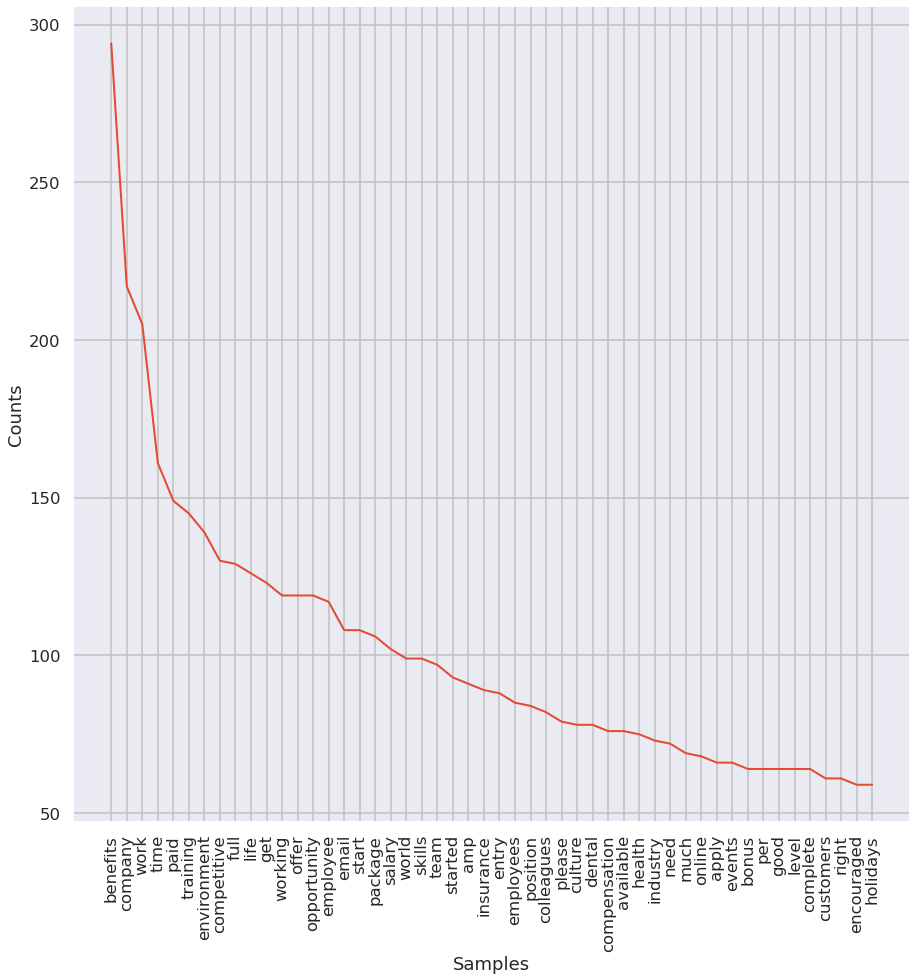

In [53]:
FreqDist(tokens_cp).plot(50)
plt.show()

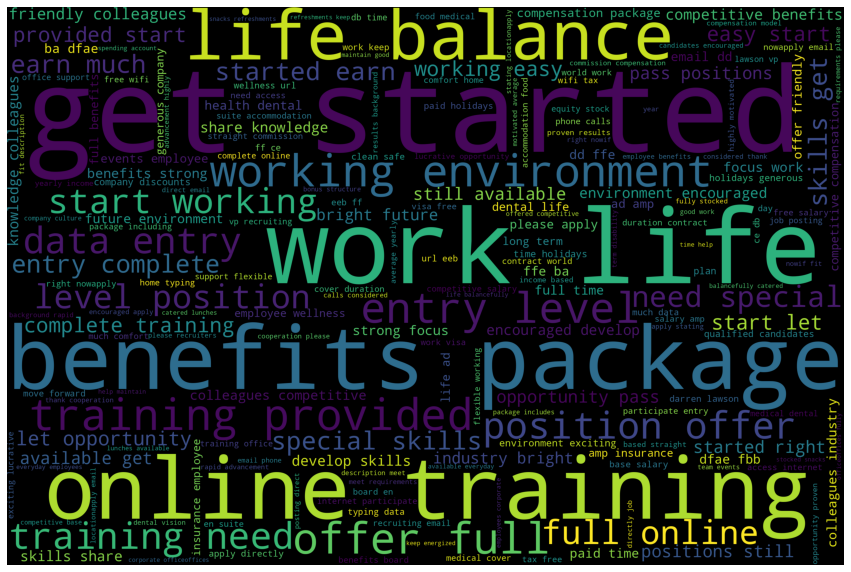

In [54]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 2.3.4.2 Description of Requirements Posts

In [55]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dflegit['Benefits']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [56]:
len(tokens_cp)

338418

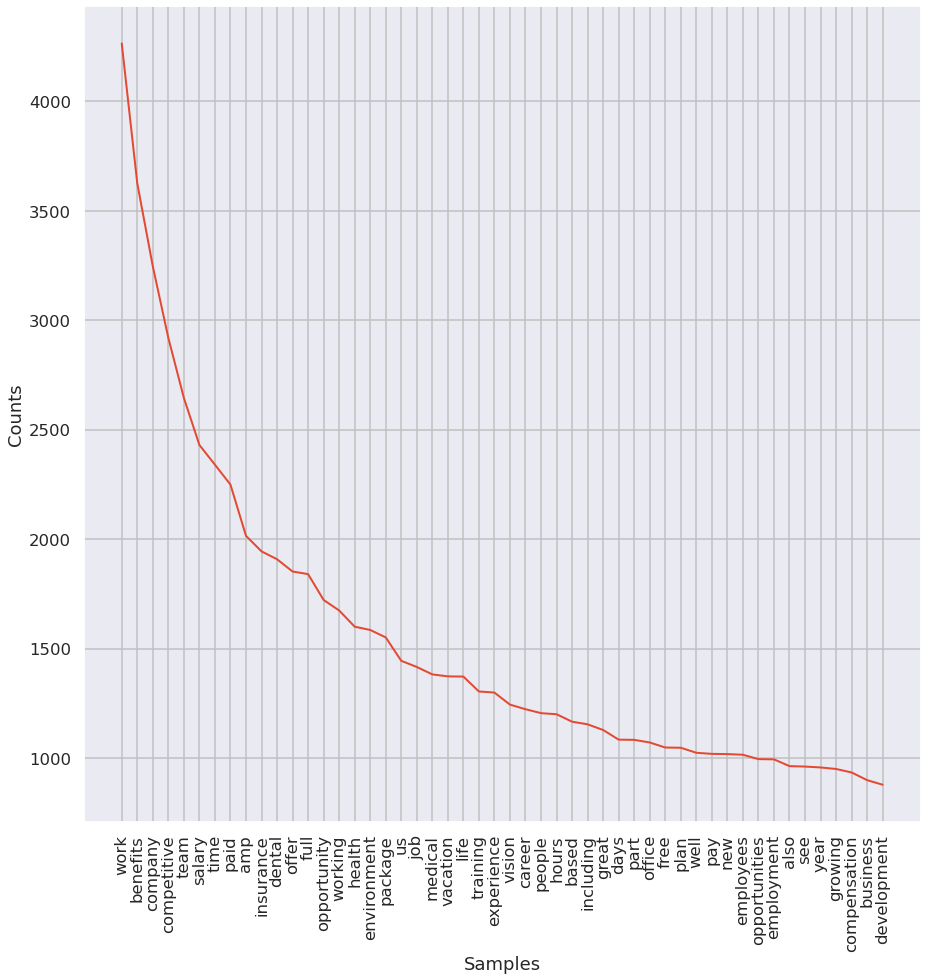

In [57]:
FreqDist(tokens_cp).plot(50)
plt.show()

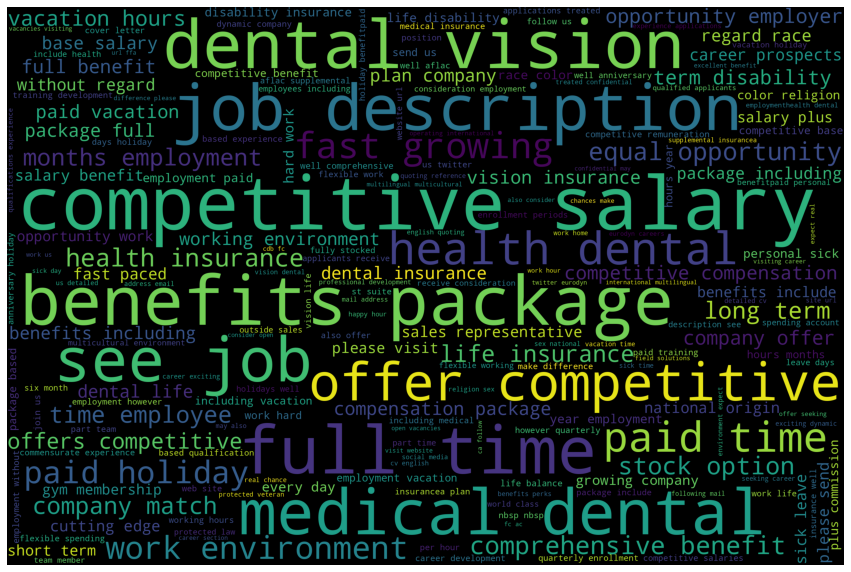

In [58]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 3. Categorical information

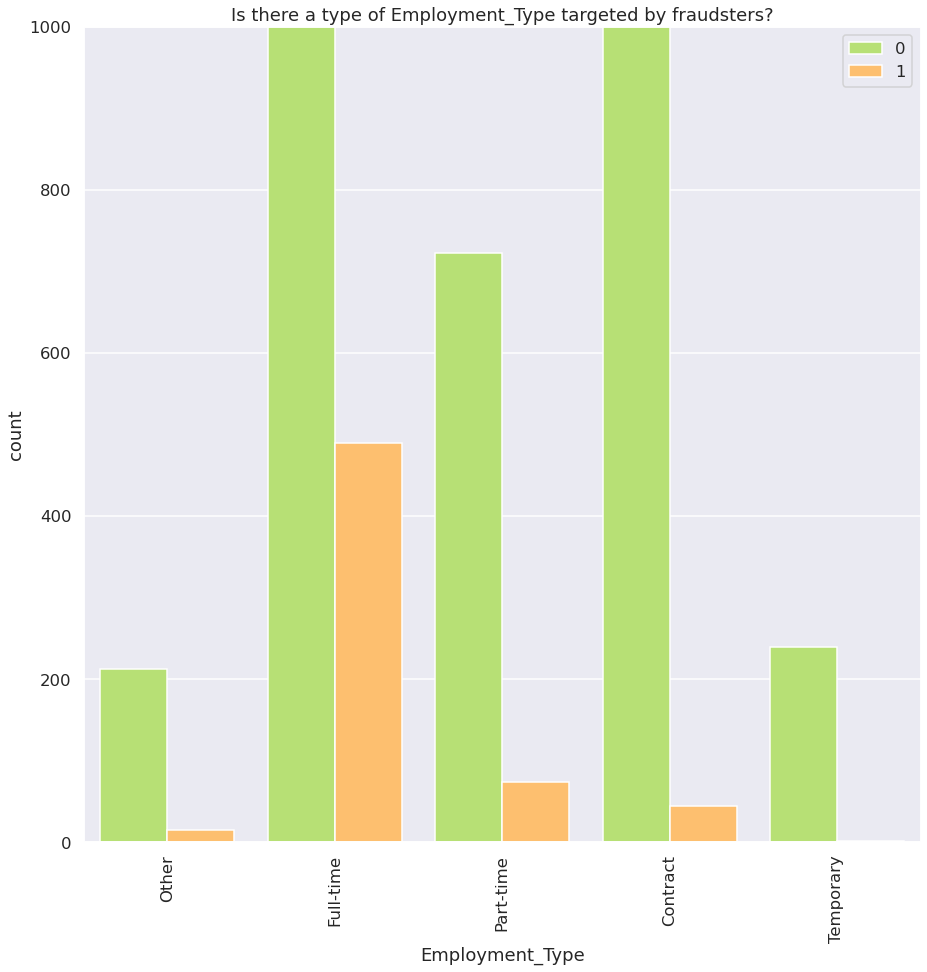

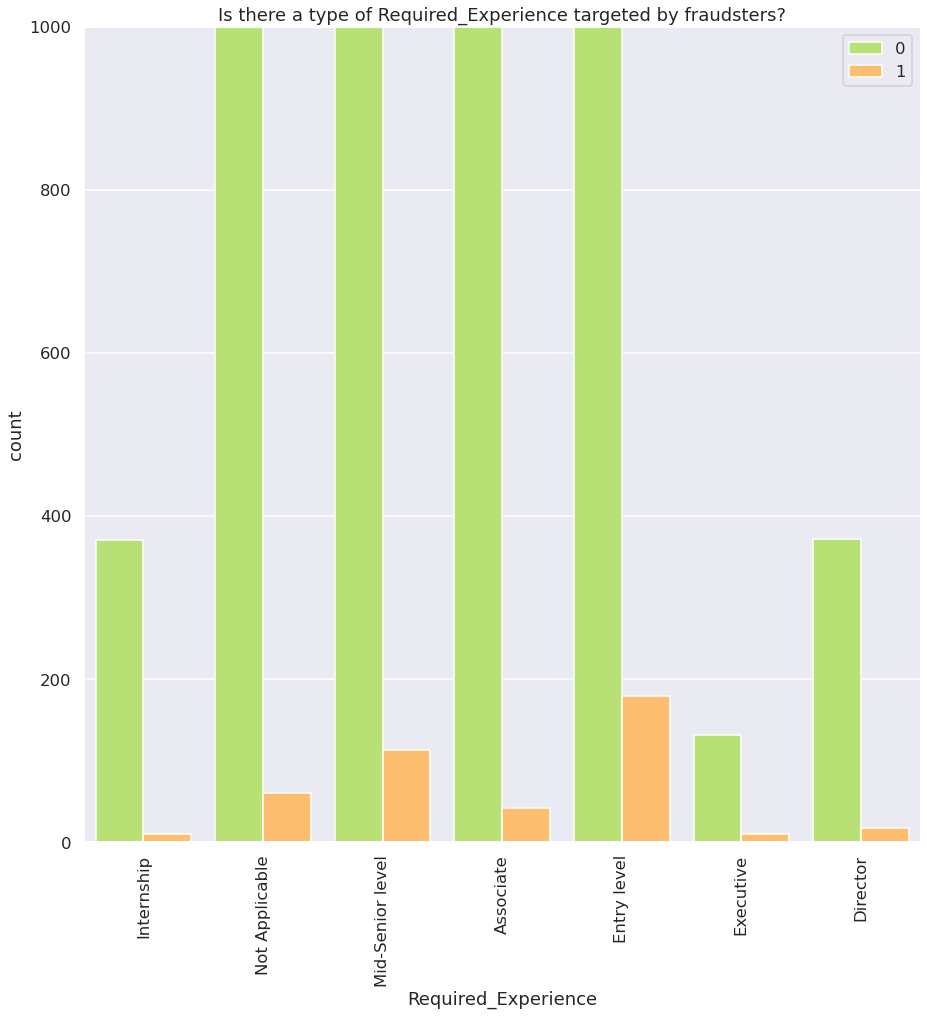

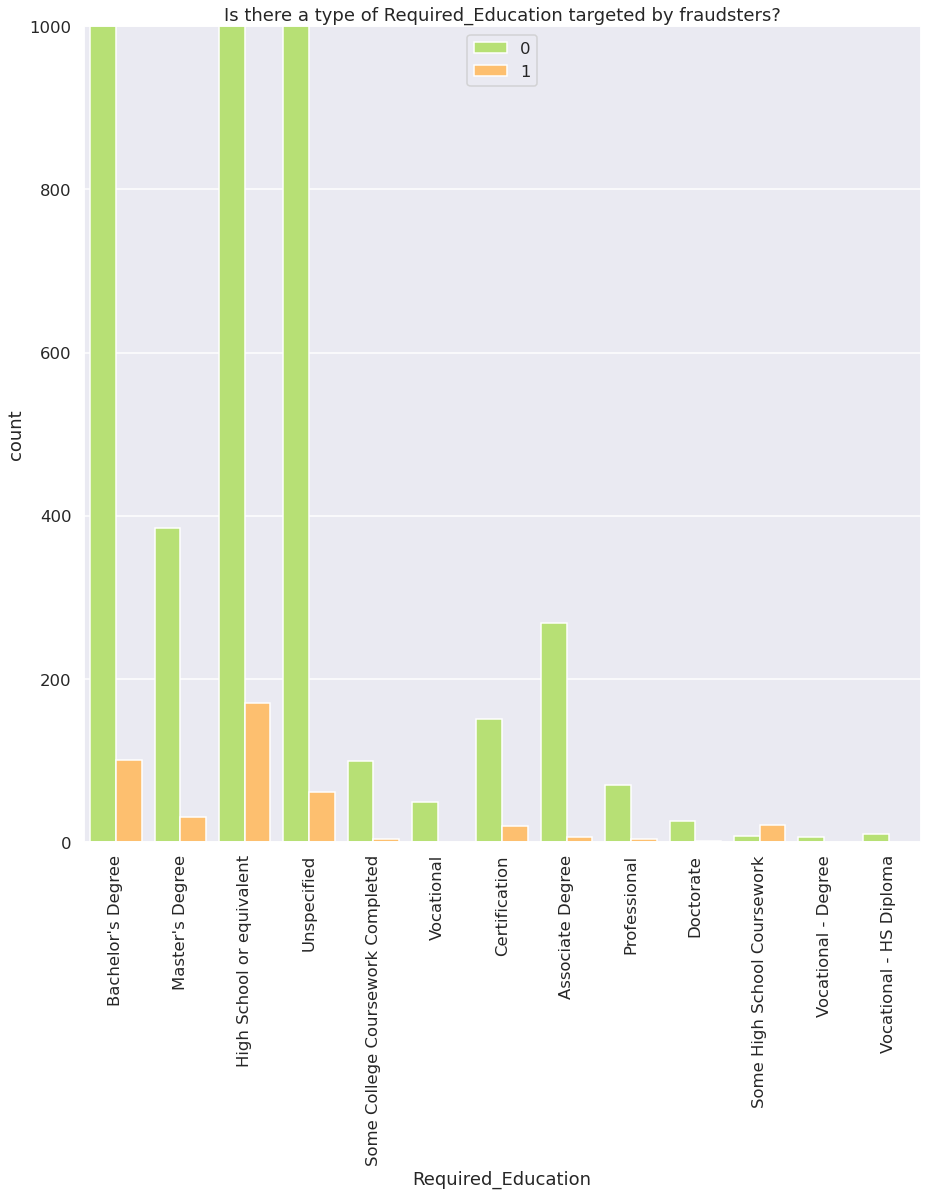

In [59]:
plots.Plots.count_plot(df,11,14)

In [60]:
vocab = {}
for i in tokens_cp:
    vocab[i] = vocab.get(i, 0) + 1

for i, t in enumerate(sorted(vocab.items(), key=lambda x:x[1], reverse=True), start=1):
    print(i, t)

1 ('work', 4264)
2 ('benefits', 3625)
3 ('company', 3246)
4 ('competitive', 2919)
5 ('team', 2645)
6 ('salary', 2430)
7 ('time', 2340)
8 ('paid', 2249)
9 ('amp', 2015)
10 ('insurance', 1944)
11 ('dental', 1908)
12 ('offer', 1852)
13 ('full', 1840)
14 ('opportunity', 1722)
15 ('working', 1674)
16 ('health', 1600)
17 ('environment', 1585)
18 ('package', 1551)
19 ('us', 1444)
20 ('job', 1416)
21 ('medical', 1382)
22 ('vacation', 1373)
23 ('life', 1372)
24 ('training', 1304)
25 ('experience', 1299)
26 ('vision', 1244)
27 ('career', 1223)
28 ('people', 1205)
29 ('hours', 1200)
30 ('based', 1166)
31 ('including', 1154)
32 ('great', 1128)
33 ('days', 1084)
34 ('part', 1083)
35 ('office', 1071)
36 ('free', 1048)
37 ('plan', 1047)
38 ('well', 1024)
39 ('pay', 1019)
40 ('new', 1018)
41 ('employees', 1015)
42 ('opportunities', 995)
43 ('employment', 994)
44 ('also', 963)
45 ('see', 961)
46 ('year', 957)
47 ('growing', 950)
48 ('compensation', 934)
49 ('business', 899)
50 ('development', 878)
51 (

1677 ('commuting', 30)
1678 ('humor', 30)
1679 ('department', 30)
1680 ('speak', 30)
1681 ('gun', 30)
1682 ('collection', 30)
1683 ('dallas', 30)
1684 ('spirit', 30)
1685 ('regularly', 30)
1686 ('integrity', 30)
1687 ('limits', 30)
1688 ('south', 30)
1689 ('prides', 30)
1690 ('maintain', 30)
1691 ('pursuit', 30)
1692 ('advertisers', 30)
1693 ('competitors', 30)
1694 ('probably', 30)
1695 ('microsoft', 30)
1696 ('responsibilities', 30)
1697 ('upstream', 30)
1698 ('demand', 30)
1699 ('beta', 30)
1700 ('enthusiastic', 30)
1701 ('child', 30)
1702 ('specific', 30)
1703 ('als', 30)
1704 ('insuranceand', 30)
1705 ('seo', 29)
1706 ('floating', 29)
1707 ('hill', 29)
1708 ('needed', 29)
1709 ('especially', 29)
1710 ('trading', 29)
1711 ('pantry', 29)
1712 ('sites', 29)
1713 ('highest', 29)
1714 ('actively', 29)
1715 ('hoursmedical', 29)
1716 ('specializes', 29)
1717 ('monitors', 29)
1718 ('determined', 29)
1719 ('sq', 29)
1720 ('delight', 29)
1721 ('tastecard', 29)
1722 ('establishments', 29)
17

2979 ('aid', 12)
2980 ('planemployee', 12)
2981 ('promotes', 12)
2982 ('comp', 12)
2983 ('planlife', 12)
2984 ('sell', 12)
2985 ('optionscool', 12)
2986 ('growthworking', 12)
2987 ('bcgmeet', 12)
2988 ('bcgersfaq', 12)
2989 ('specialist', 12)
2990 ('budgets', 12)
2991 ('extend', 12)
2992 ('beginning', 12)
2993 ('corporates', 12)
2994 ('runner', 12)
2995 ('resum', 12)
2996 ('hardworking', 12)
2997 ('planmobile', 12)
2998 ('workattendance', 12)
2999 ('projectsflexible', 12)
3000 ('divisions', 12)
3001 ('limousine', 12)
3002 ('copenhagen', 12)
3003 ('affect', 12)
3004 ('cubicle', 12)
3005 ('architecture', 12)
3006 ('entitled', 12)
3007 ('agreed', 12)
3008 ('poker', 12)
3009 ('spiritual', 12)
3010 ('served', 12)
3011 ('roll', 12)
3012 ('purchases', 12)
3013 ('regarding', 12)
3014 ('benefitsmedical', 12)
3015 ('insuranceoptional', 12)
3016 ('specialized', 12)
3017 ('exceeding', 12)
3018 ('bp', 12)
3019 ('privilege', 12)
3020 ('nimble', 12)
3021 ('detail', 12)
3022 ('approximately', 12)
3023

4606 ('fulltime', 6)
4607 ('shirt', 6)
4608 ('filipinos', 6)
4609 ('salarybe', 6)
4610 ('sonos', 6)
4611 ('salaryperformance', 6)
4612 ('jump', 6)
4613 ('stuffwork', 6)
4614 ('besides', 6)
4615 ('transcripts', 6)
4616 ('opportunitiesmileage', 6)
4617 ('session', 6)
4618 ('ppay', 6)
4619 ('yearpaid', 6)
4620 ('laptops', 6)
4621 ('although', 6)
4622 ('attributes', 6)
4623 ('gmt', 6)
4624 ('karaoke', 6)
4625 ('revolutionary', 6)
4626 ('significantly', 6)
4627 ('residential', 6)
4628 ('island', 6)
4629 ('farm', 6)
4630 ('hillshire', 6)
4631 ('ball', 6)
4632 ('sint', 6)
4633 ('semper', 6)
4634 ('atomorum', 6)
4635 ('habeo', 6)
4636 ('blandit', 6)
4637 ('sapientem', 6)
4638 ('nullam', 6)
4639 ('deseruisse', 6)
4640 ('vix', 6)
4641 ('nominavi', 6)
4642 ('tincidunt', 6)
4643 ('temporibus', 6)
4644 ('liber', 6)
4645 ('mucius', 6)
4646 ('oportere', 6)
4647 ('hinc', 6)
4648 ('quaeque', 6)
4649 ('sensibus', 6)
4650 ('omnium', 6)
4651 ('audiam', 6)
4652 ('corpora', 6)
4653 ('legere', 6)
4654 ('iisq

5922 ('messy', 4)
5923 ('smelly', 4)
5924 ('foodflexible', 4)
5925 ('paths', 4)
5926 ('nl', 4)
5927 ('viewing', 4)
5928 ('decided', 4)
5929 ('curalate', 4)
5930 ('hundred', 4)
5931 ('stuck', 4)
5932 ('cal', 4)
5933 ('charities', 4)
5934 ('scandinavian', 4)
5935 ('israelies', 4)
5936 ('sum', 4)
5937 ('korean', 4)
5938 ('oacute', 4)
5939 ('loyalty', 4)
5940 ('knowing', 4)
5941 ('norm', 4)
5942 ('abd', 4)
5943 ('volunteering', 4)
5944 ('leavepaid', 4)
5945 ('allocated', 4)
5946 ('bessemer', 4)
5947 ('physician', 4)
5948 ('qualificationsbonuses', 4)
5949 ('guaranteedbenefits', 4)
5950 ('daysjoining', 4)
5951 ('trainingcar', 4)
5952 ('hence', 4)
5953 ('valid', 4)
5954 ('purolator', 4)
5955 ('packagesrelocation', 4)
5956 ('foot', 4)
5957 ('welfare', 4)
5958 ('fnatic', 4)
5959 ('procurement', 4)
5960 ('pfizer', 4)
5961 ('behavior', 4)
5962 ('pictures', 4)
5963 ('jag', 4)
5964 ('adhwaryu', 4)
5965 ('minority', 4)
5966 ('baad', 4)
5967 ('ccaa', 4)
5968 ('cbbecf', 4)
5969 ('ceaaa', 4)
5970 ('fda

7394 ('lenses', 2)
7395 ('designs', 2)
7396 ('scypho', 2)
7397 ('bonusequityprivate', 2)
7398 ('subsidyfree', 2)
7399 ('benefitsno', 2)
7400 ('abilitiescompetitive', 2)
7401 ('insurancecool', 2)
7402 ('williamsburg', 2)
7403 ('manhattansmall', 2)
7404 ('teampets', 2)
7405 ('welcomesnacks', 2)
7406 ('dailypick', 2)
7407 ('describing', 2)
7408 ('friendliness', 2)
7409 ('farms', 2)
7410 ('hall', 2)
7411 ('eec', 2)
7412 ('birmingham', 2)
7413 ('blloon', 2)
7414 ('cbac', 2)
7415 ('bfca', 2)
7416 ('proffesional', 2)
7417 ('biedt', 2)
7418 ('dynamische', 2)
7419 ('internationale', 2)
7420 ('werkomgeving', 2)
7421 ('kansen', 2)
7422 ('terecht', 2)
7423 ('jouw', 2)
7424 ('extralegale', 2)
7425 ('harrigan', 2)
7426 ('accountability', 2)
7427 ('endeavors', 2)
7428 ('sake', 2)
7429 ('enabler', 2)
7430 ('justice', 2)
7431 ('mncs', 2)
7432 ('def', 2)
7433 ('dcecfa', 2)
7434 ('unrivalled', 2)
7435 ('stunning', 2)
7436 ('jod', 2)
7437 ('zomato', 2)
7438 ('pack', 2)
7439 ('equitythis', 2)
7440 ('emplom

8916 ('ecbe', 2)
8917 ('peoplework', 2)
8918 ('essence', 2)
8919 ('organizationa', 2)
8920 ('mto', 2)
8921 ('cms', 2)
8922 ('ovummore', 2)
8923 ('clientswe', 2)
8924 ('offeryou', 2)
8925 ('judge', 2)
8926 ('eop', 2)
8927 ('termination', 2)
8928 ('offnote', 2)
8929 ('roadblocks', 2)
8930 ('hts', 2)
8931 ('navigation', 2)
8932 ('split', 2)
8933 ('businessresponsibility', 2)
8934 ('geta', 2)
8935 ('codea', 2)
8936 ('ceu', 2)
8937 ('accumulating', 2)
8938 ('expecttry', 2)
8939 ('devops', 2)
8940 ('bonusprofessional', 2)
8941 ('highprofile', 2)
8942 ('capistrano', 2)
8943 ('packageall', 2)
8944 ('toolstraining', 2)
8945 ('informally', 2)
8946 ('thrilled', 2)
8947 ('suzanne', 2)
8948 ('brandt', 2)
8949 ('eventsbirthday', 2)
8950 ('perkscompetitive', 2)
8951 ('airfare', 2)
8952 ('immunizations', 2)
8953 ('landline', 2)
8954 ('headset', 2)
8955 ('ease', 2)
8956 ('advise', 2)
8957 ('xx', 2)
8958 ('gyms', 2)
8959 ('packagebecome', 2)
8960 ('peoplecompetitive', 2)
8961 ('restaurantspotify', 2)
89

10547 ('uitbreiding', 1)
10548 ('subsequently', 1)
10549 ('officials', 1)
10550 ('ceos', 1)
10551 ('worldwideplease', 1)
10552 ('providedcompany', 1)
10553 ('airrapid', 1)
10554 ('advancementno', 1)
10555 ('offerone', 1)
10556 ('marketingwe', 1)
10557 ('downright', 1)
10558 ('friendlyintensive', 1)
10559 ('routean', 1)
10560 ('bonushigh', 1)
10561 ('notebook', 1)
10562 ('jungleon', 1)
10563 ('quantified', 1)
10564 ('implicitly', 1)
10565 ('cognitive', 1)
10566 ('mood', 1)
10567 ('sensor', 1)
10568 ('pilot', 1)
10569 ('scientists', 1)
10570 ('neuro', 1)
10571 ('psychology', 1)
10572 ('redpoint', 1)
10573 ('geoff', 1)
10574 ('yang', 1)
10575 ('michael', 1)
10576 ('dearing', 1)
10577 ('mike', 1)
10578 ('hirshland', 1)
10579 ('tim', 1)
10580 ('draper', 1)
10581 ('sunnier', 1)
10582 ('weeklypaid', 1)
10583 ('ireland', 1)
10584 ('insurancevacationholidays', 1)
10585 ('accountlong', 1)
10586 ('dont', 1)
10587 ('recoverys', 1)
10588 ('bye', 1)
10589 ('insurancecompetitive', 1)
10590 ('compensa

12193 ('probationbenefits', 1)
12194 ('bonusplease', 1)
12195 ('purposesonly', 1)
12196 ('hotshot', 1)
12197 ('outfits', 1)
12198 ('ocio', 1)
12199 ('islas', 1)
12200 ('entertainer', 1)
12201 ('darling', 1)
12202 ('environmentdaily', 1)
12203 ('eventsaccess', 1)
12204 ('screeningsexposure', 1)
12205 ('peepsfully', 1)
12206 ('breakfastrooftop', 1)
12207 ('gymfriday', 1)
12208 ('hoursaccess', 1)
12209 ('employeespaid', 1)
12210 ('growthraisesbonuses', 1)
12211 ('compensationhourly', 1)
12212 ('uo', 1)
12213 ('clock', 1)
12214 ('locationgkazi', 1)
12215 ('plateia', 1)
12216 ('kerameikou', 1)
12217 ('cvsapplicants', 1)
12218 ('salinas', 1)
12219 ('versus', 1)
12220 ('indoors', 1)
12221 ('tahoe', 1)
12222 ('negotiablehealth', 1)
12223 ('savingslong', 1)
12224 ('disabilitypto', 1)
12225 ('signifcant', 1)
12226 ('potentialpromotion', 1)
12227 ('culinary', 1)
12228 ('trailblazing', 1)
12229 ('critically', 1)
12230 ('acclaim', 1)
12231 ('approaching', 1)
12232 ('pit', 1)
12233 ('salaryshape', 1

13878 ('tower', 1)
13879 ('freelancing', 1)
13880 ('positionpossibility', 1)
13881 ('periodflexibility', 1)
13882 ('wil', 1)
13883 ('contractwork', 1)
13884 ('pozna', 1)
13885 ('cardmedical', 1)
13886 ('netguru', 1)
13887 ('dinnersteam', 1)
13888 ('eventssandwiches', 1)
13889 ('morningtea', 1)
13890 ('hourexcellent', 1)
13891 ('eurlearning', 1)
13892 ('jobenergetic', 1)
13893 ('planptointerested', 1)
13894 ('folksstartup', 1)
13895 ('marketresponsibility', 1)
13896 ('professionalbeing', 1)
13897 ('requiredlaptopconcierge', 1)
13898 ('enefits', 1)
13899 ('planadditional', 1)
13900 ('guardianfour', 1)
13901 ('beeeed', 1)
13902 ('returna', 1)
13903 ('processingmysqllinuxvideo', 1)
13904 ('protocolsvideo', 1)
13905 ('standardsinternet', 1)
13906 ('securityalgorithm', 1)
13907 ('matlabsoftware', 1)
13908 ('qaexperience', 1)
13909 ('benefitswhy', 1)
13910 ('oct', 1)
13911 ('nov', 1)
13912 ('radico', 1)
13913 ('etsy', 1)
13914 ('retouching', 1)
13915 ('occupies', 1)
13916 ('publicis', 1)
1391

14983 ('relying', 1)
14984 ('economies', 1)
14985 ('aircompetitive', 1)
14986 ('optionsteam', 1)
14987 ('charitiesgreat', 1)
14988 ('spacefree', 1)
14989 ('holidaystwo', 1)
14990 ('rocks', 1)
14991 ('insturanceongoing', 1)
14992 ('wageworks', 1)
14993 ('convincing', 1)
14994 ('ozufyfwg', 1)
14995 ('ukexclusive', 1)
14996 ('piecekeeper', 1)
14997 ('onepiece', 1)
14998 ('ambassador', 1)
14999 ('programmebe', 1)
15000 ('facebookto', 1)
15001 ('codesealer', 1)
15002 ('tilbyder', 1)
15003 ('dig', 1)
15004 ('godt', 1)
15005 ('arbejdsmilj', 1)
15006 ('dygtige', 1)
15007 ('engagerede', 1)
15008 ('kolleger', 1)
15009 ('stor', 1)
15010 ('faglighed', 1)
15011 ('jt', 1)
15012 ('hum', 1)
15013 ('ske', 1)
15014 ('ikke', 1)
15015 ('mindst', 1)
15016 ('uformel', 1)
15017 ('hvor', 1)
15018 ('forskelligheder', 1)
15019 ('muligheden', 1)
15020 ('blive', 1)
15021 ('arbejder', 1)
15022 ('unikt', 1)
15023 ('produkt', 1)
15024 ('faglige', 1)
15025 ('udfordringer', 1)
15026 ('nyeste', 1)
15027 ('teknologier',

## 4. Extracting extra information

Some job offers have a phone, email and/or external URL information:

In [61]:
for column in df.columns:
    df[column].fillna('NA', inplace=True)
    
df = df.assign(HasEMAIL=0, HasPHONE=0, HasURL=0)
for column in df.columns[4:8]:
    for i in range(1,len(df[column])):
        if df[column][i].find('#URL_')!=-1:
            df['HasURL'][i] = 1
    for i in range(1,len(df[column])):
        if df[column][i].find('#PHONE_')!=-1:
            df['HasPHONE'][i] = 1
    for i in range(1,len(df[column])):
        if df[column][i].find('#EMAIL_')!=-1:
            df['HasEMAIL'][i] = 1

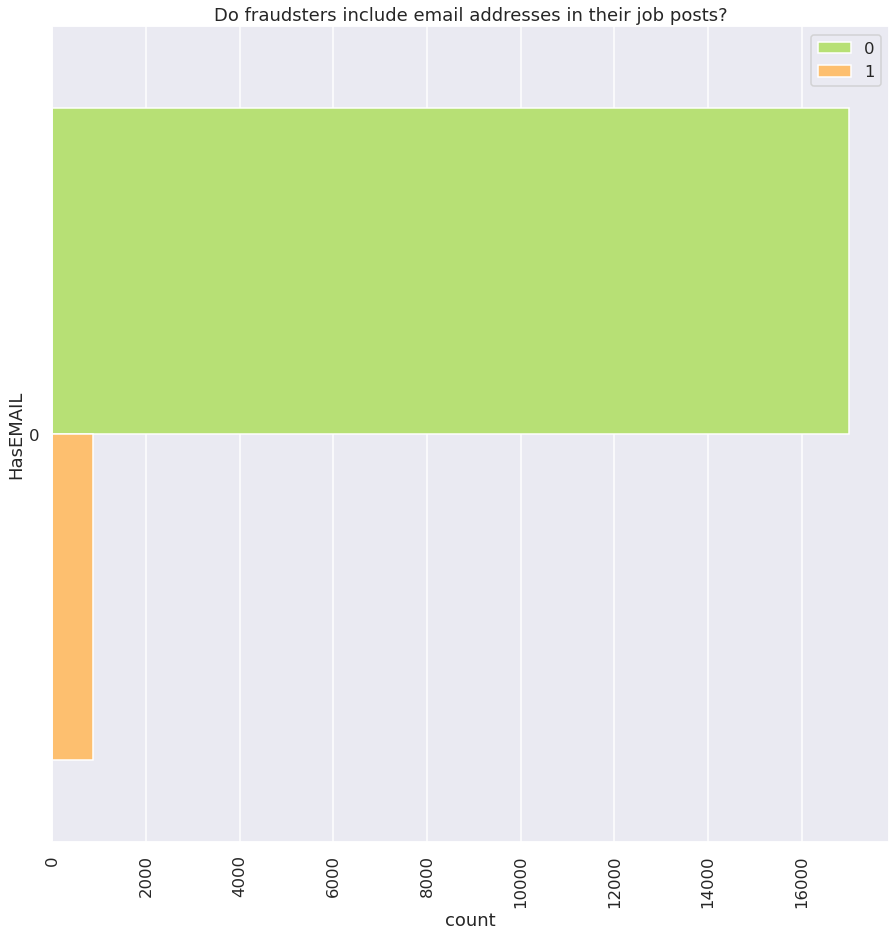

In [62]:
sns.countplot(y='HasEMAIL', hue='Fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include email addresses in their job posts?")
plt.xticks(rotation=90);
plt.legend();

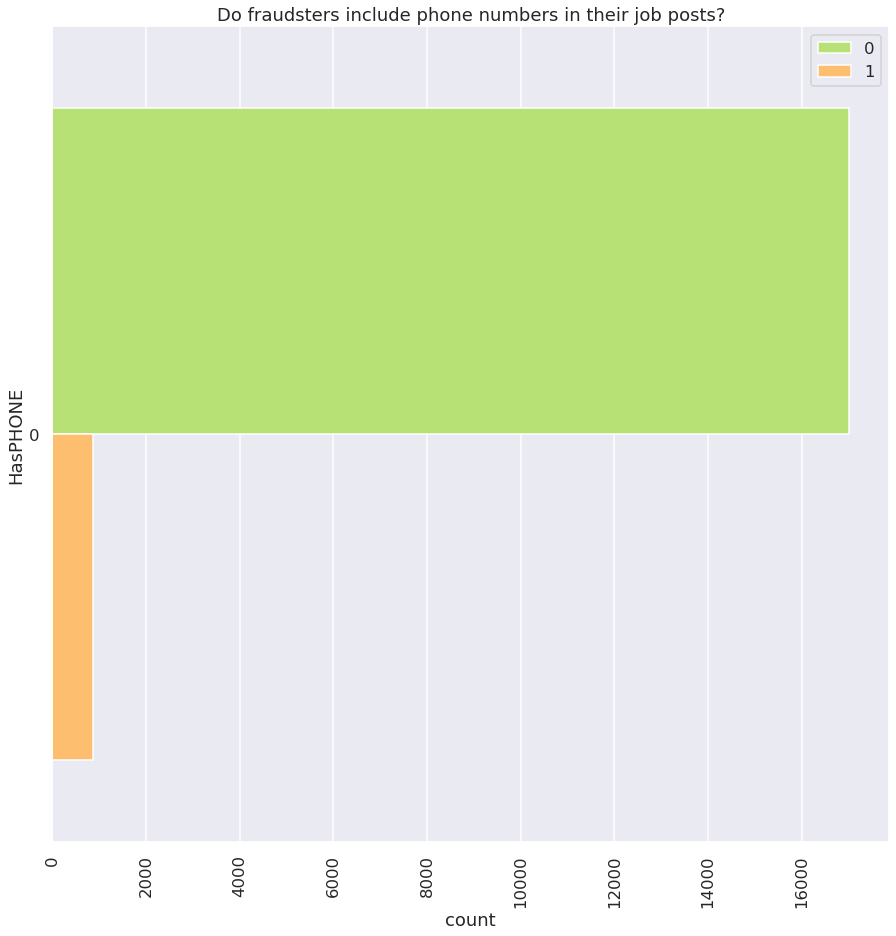

In [63]:
sns.countplot(y='HasPHONE', hue='Fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include phone numbers in their job posts?")
plt.xticks(rotation=90);
plt.legend();

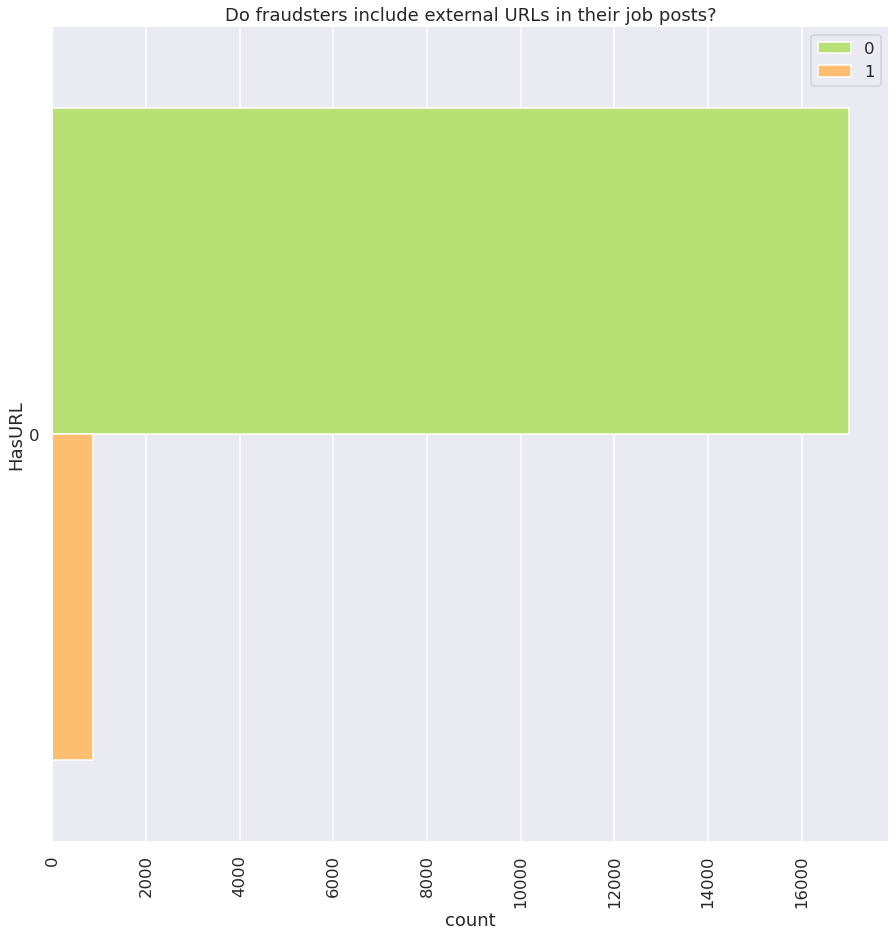

In [64]:
sns.countplot(y='HasURL', hue='Fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include external URLs in their job posts?")
plt.xticks(rotation=90);
plt.legend();

## 5. Conclusion
Unfortunately looking at the metadata is not going to be enough to identify fraudulent job posts. The fraudulent job posts follow the same pattern as legitimate job posts except:
* they tend to be lacking more information than the genuine job offers but, fraudsters will make an effort for information such as location, department, function and especially salary_range.
* when information is provided, it will tend to be shorter, the text is going to be more succinct. This characteristic is especially true for the company profile and the job requirements fields.

In terms of content, fraudulent posts will:
* target 'High school degrees or equivalent' and 'Bachelor's Degree' more than any other type of education; Doctorate, Associate Degrees and Vocational were not particularly targeted, some even not targeted at all (in this dataset at least).
* mostly advertise full-time and part-time positions. There are a few fraudulent contractor positions but, proportionally less than any other type of position and temporary contracts were not targeted at all (in this dataset at least).
* target all types of experience but mainly entry-level positions. Once again, Associates are less exposed whilst Directors, Executive and Mid-Senior levels are a little less exposed too.
* tend to refer an URL.  This URL is potentially linking to a website that will infect the victim's computer but, as phone, emails and URLs have been anonymised, it is impossible to confirm this hypothesis.
* NOT communicate a phone number. But most job ads don't anyways.

I hope this gives you a little bit more understanding of fraudulent job offers. The [following notebook](./index.ipynb) will go deeper in the analysis of this dataset and will result in the creation of a classification model helping identify the legitimacy of job posts.